In [260]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive 마운트가 완료되었습니다.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive 마운트가 완료되었습니다.


In [88]:
# 필수 라이브러리 설치
!pip install tifffile imagecodecs rasterio

# 라이브러리 임포트
# 라이브러리 수정
import os
import glob
import numpy as np
import tifffile
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

print("✅ 필요한 라이브러리 임포트가 완료되었습니다.")

✅ 필요한 라이브러리 임포트가 완료되었습니다.


In [89]:
# 폰트 설치

# 0) 시스템 폰트 설치 (나눔고딕 + 대체용 Noto CJK)
!apt-get update -qq
!apt-get install -y fonts-nanum fonts-noto-cjk > /dev/null

import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 1) Matplotlib 폰트 캐시 제거 후 강제 리빌드
try:
    import shutil
    cache_dir = os.path.expanduser("~/.cache/matplotlib")
    if os.path.exists(cache_dir):
        shutil.rmtree(cache_dir)
except Exception as e:
    print("캐시 삭제 중 경고:", e)

# 2) 후보 경로에서 폰트 파일 찾기
candidates = [
    "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",          # 가장 선호
    "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc",   # 대체 1
    "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",   # 대체 2 (환경에 따라 위치가 다름)
]

font_path = None
for p in candidates:
    if os.path.exists(p):
        font_path = p
        break

if font_path is None:
    raise FileNotFoundError("한글 폰트를 찾지 못했습니다. 위 apt-get 설치 로그를 확인해 주세요.")

# 3) 폰트를 Matplotlib에 등록(addfont) 후, 패밀리명 얻기
fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()

# 4) 전역 설정 적용
mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False

print(f"한글 폰트 적용: {font_name} @ {font_path}")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
한글 폰트 적용: NanumGothic @ /usr/share/fonts/truetype/nanum/NanumGothic.ttf


In [133]:
import pandas as pd

GDRIVE_BASE_PATH = "/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset"

customers = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/olist_customers_dataset.csv")
geolocation = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/olist_geolocation_dataset.csv")
order_items = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/olist_order_items_dataset.csv")
order_payments = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/olist_order_reviews_dataset.csv")
orders = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/olist_orders_dataset.csv")
products = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/olist_products_dataset.csv")
sellers = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/olist_sellers_dataset.csv")
category_name = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/product_category_name_translation.csv")

### 데이터 확인

In [134]:
customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [135]:
customers.shape

(99441, 5)

In [136]:
geolocation

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


In [137]:
geolocation.shape

(1000163, 5)

In [138]:
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [139]:
order_items.shape

(112650, 7)

In [140]:
order_payments

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


In [141]:
order_payments.shape

(103886, 5)

In [142]:
order_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [143]:
order_reviews.shape

(99224, 7)

In [144]:
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [145]:
orders.shape

(99441, 8)

In [146]:
products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [147]:
products.shape

(32951, 9)

In [148]:
sellers

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


In [149]:
sellers.shape

(3095, 4)

In [150]:
category_name

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,flores,flowers
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes


In [151]:
category_name.shape

(71, 2)

### EDA

In [152]:
# order_reviews 결측치 확인
order_reviews.isna().sum()

,0
review_id,0
order_id,0
review_score,0
review_comment_title,87656
review_comment_message,58247
review_creation_date,0
review_answer_timestamp,0


In [153]:
# order_payments - payment_installments 할부 개월 수 고유값 확인
order_payments['payment_installments'].unique()

array([ 8,  1,  2,  3,  6,  5,  4, 10,  7, 12,  9, 13, 15, 24, 11, 18, 14,
       20, 21, 17, 22,  0, 16, 23])

In [154]:
# order_payments - payment_installments 할부 개월 수별 구매 횟수 확인
order_payments['payment_installments'].value_counts().sort_values(ascending=False)

,count
payment_installments,
1,52546
2,12413
3,10461
4,7098
10,5328
5,5239
8,4268
6,3920
7,1626


In [155]:
display(order_payments['payment_type'].value_counts())

,count
payment_type,
credit_card,76795
boleto,19784
voucher,5775
debit_card,1529
not_defined,3


In [156]:
orders['order_purchase_timestamp'].unique()

array(['2017-10-02 10:56:33', '2018-07-24 20:41:37',
       '2018-08-08 08:38:49', ..., '2017-08-27 14:46:43',
       '2018-01-08 21:28:27', '2018-03-08 20:57:30'], dtype=object)

### 데이터 병합

In [157]:
df_train = orders.merge(order_items, on='order_id', how='left')
df_train = df_train.merge(order_payments, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(order_reviews, on='order_id', how='outer')
df_train = df_train.merge(products, on='product_id', how='outer')
df_train = df_train.merge(customers, on='customer_id', how='outer')
df_train = df_train.merge(sellers, on='seller_id', how='outer')

df_train

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,d455a8cb295653b55abda06d434ab492,944b72539d7e1f7f7fc6e46639ef1fe3,delivered,2017-09-26 22:17:05,2017-09-27 22:24:16,2017-09-29 15:53:03,2017-10-07 16:12:47,2017-10-30 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,40.0,43.0,36.0,3c7e305796add66698959fc7ad176f6b,87502,umuarama,PR,9080.0,santo andre,SP
1,7f39ba4c9052be115350065d07583cac,d7fc82cbeafea77bd0a8fbbf6296e387,delivered,2017-10-18 08:16:34,2017-10-18 23:56:20,2017-10-20 14:29:01,2017-10-27 16:46:05,2017-11-09 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,40.0,43.0,36.0,9de5797cddb92598755a0f76383ddbbb,35490,entre rios de minas,MG,9080.0,santo andre,SP
2,9dc8d1a6f16f1b89874c29c9d8d30447,d9442164acf4b03109425633efaa0cfc,delivered,2017-10-12 13:33:22,2017-10-12 13:49:22,2017-10-17 15:42:42,2017-10-24 20:17:44,2017-11-06 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,40.0,43.0,36.0,9915eb9f74b6c11aaf04833f65b00e93,38600,paracatu,MG,9080.0,santo andre,SP
3,0f548bd29148ebc519d6495e37a284e1,015faf9ec36eccd957c0f2782aab09a4,delivered,2017-09-03 08:06:30,2017-09-03 08:25:50,2017-09-04 22:03:06,2017-09-08 16:26:55,2017-09-27 00:00:00,1.0,08574b074924071f4e201e151b152b4e,...,42.0,12.0,39.0,dce323533e45e74d215e0fe7fb114118,24710,sao goncalo,RJ,29156.0,cariacica,ES
4,0f548bd29148ebc519d6495e37a284e1,015faf9ec36eccd957c0f2782aab09a4,delivered,2017-09-03 08:06:30,2017-09-03 08:25:50,2017-09-04 22:03:06,2017-09-08 16:26:55,2017-09-27 00:00:00,2.0,08574b074924071f4e201e151b152b4e,...,42.0,12.0,39.0,dce323533e45e74d215e0fe7fb114118,24710,sao goncalo,RJ,29156.0,cariacica,ES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,87ae60ef8b08ae0e5f903cacb53a6904,fea4d57ed3a45455f89c25ef3dae8ee8,canceled,2018-09-11 16:45:54,NaN,NaN,NaN,2018-09-26 00:00:00,NaN,NaN,...,NaN,NaN,NaN,09687a7b7431a93b5c53b50ba779bf94,12010,taubate,SP,NaN,NaN,NaN
119139,d69fcef5a5fe3a3db60ea65c6ee499cc,ff0340330283c0d05ea7281e67fa2e76,unavailable,2017-12-02 10:11:44,2017-12-02 10:30:31,NaN,NaN,2018-01-08 00:00:00,NaN,NaN,...,NaN,NaN,NaN,dc80a79483121fee90b0d2f53d1054f5,57046,maceio,AL,NaN,NaN,NaN
119140,f86d7bc39aab05299691322044b63bb2,ff31bee1ba4bba00cc14b1b91c8d28f3,canceled,2018-08-13 18:43:06,NaN,NaN,NaN,2018-09-25 00:00:00,NaN,NaN,...,NaN,NaN,NaN,a0931a30dcf7e2106f0939b799c54321,76804,porto velho,RO,NaN,NaN,NaN
119141,74f833bf7c70ce8c3f820f725c213e1c,fffc22669ca576ae3f654ea64c8f36be,unavailable,2017-06-30 11:21:11,2017-06-30 11:30:20,NaN,NaN,2017-08-01 00:00:00,NaN,NaN,...,NaN,NaN,NaN,0f21adf44f13a61282678a89f6433c10,40255,salvador,BA,NaN,NaN,NaN


In [158]:
df_train.shape

(119143, 39)

In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)

    return summary

def cross_heatmap(df, cols, normalize=False, values=None, aggfunc=None):
    temp = cols
    cm = sns.light_palette("green", as_cmap=True)
    return pd.crosstab(df[temp[0]], df[temp[1]],
                       normalize=normalize, values=values, aggfunc=aggfunc).style.background_gradient(cmap = cm)

resumetable(df_train)

Dataset Shape: (119143, 39)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,order_id,object,0,99441,d455a8cb295653b55abda06d434ab492,7f39ba4c9052be115350065d07583cac,9dc8d1a6f16f1b89874c29c9d8d30447,16.46
1,customer_id,object,0,99441,944b72539d7e1f7f7fc6e46639ef1fe3,d7fc82cbeafea77bd0a8fbbf6296e387,d9442164acf4b03109425633efaa0cfc,16.46
2,order_status,object,0,8,delivered,delivered,delivered,0.25
3,order_purchase_timestamp,object,0,98875,2017-09-26 22:17:05,2017-10-18 08:16:34,2017-10-12 13:33:22,16.44
4,order_approved_at,object,177,90733,2017-09-27 22:24:16,2017-10-18 23:56:20,2017-10-12 13:49:22,16.28
5,order_delivered_carrier_date,object,2086,81018,2017-09-29 15:53:03,2017-10-20 14:29:01,2017-10-17 15:42:42,16.03
6,order_delivered_customer_date,object,3421,95664,2017-10-07 16:12:47,2017-10-27 16:46:05,2017-10-24 20:17:44,16.40
7,order_estimated_delivery_date,object,0,459,2017-10-30 00:00:00,2017-11-09 00:00:00,2017-11-06 00:00:00,8.47
8,order_item_id,float64,833,21,1.0,1.0,1.0,0.72
9,product_id,object,833,32951,a2ff5a97bf95719e38ea2e3b4105bce8,a2ff5a97bf95719e38ea2e3b4105bce8,a2ff5a97bf95719e38ea2e3b4105bce8,13.63


In [160]:
df_train.corr(numeric_only=True)

,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_zip_code_prefix,seller_zip_code_prefix
order_item_id,1.000000,-0.060459,-0.030694,-0.002871,0.073835,0.265217,-0.129398,-0.024155,-0.015059,-0.054455,-0.004326,0.005348,0.029172,-0.009461,-0.000528,-0.018331
price,-0.060459,1.000000,0.415938,0.006839,0.277642,0.739236,-0.004492,0.018026,0.201759,0.052818,0.339367,0.145587,0.224309,0.172629,0.043158,0.088363
freight_value,-0.030694,0.415938,1.000000,0.022345,0.185674,0.373762,-0.037013,0.022628,0.096506,0.022329,0.611587,0.309672,0.393865,0.325325,0.225510,0.152086
payment_sequential,-0.002871,0.006839,0.022345,1.000000,-0.086508,-0.064467,-0.005766,-0.005581,0.009937,-0.010828,0.043985,0.048959,0.024479,0.031062,-0.021974,0.014274
payment_installments,0.073835,0.277642,0.185674,-0.086508,1.000000,0.273647,-0.040446,0.020843,0.036004,0.000118,0.177491,0.117630,0.122231,0.137857,0.056266,0.039097
payment_value,0.265217,0.739236,0.373762,-0.064467,0.273647,1.000000,-0.082343,0.002371,0.156108,0.010075,0.303326,0.138755,0.217155,0.148606,0.054519,0.069818
review_score,-0.129398,-0.004492,-0.037013,-0.005766,-0.040446,-0.082343,1.000000,-0.006239,0.010332,0.022304,-0.028622,-0.020390,-0.026405,-0.010709,-0.021886,0.026024
product_name_lenght,-0.024155,0.018026,0.022628,-0.005581,0.020843,0.002371,-0.006239,1.000000,0.090238,0.145439,0.020736,0.058652,-0.030891,0.062133,0.015804,-0.032688
product_description_lenght,-0.015059,0.201759,0.096506,0.009937,0.036004,0.156108,0.010332,0.090238,1.000000,0.117888,0.063577,0.007468,0.074121,-0.068269,0.025415,0.062260
product_photos_qty,-0.054455,0.052818,0.022329,-0.010828,0.000118,0.010075,0.022304,0.145439,0.117888,1.000000,0.021535,0.044662,-0.033464,0.006953,0.020505,-0.042118


<Axes: >

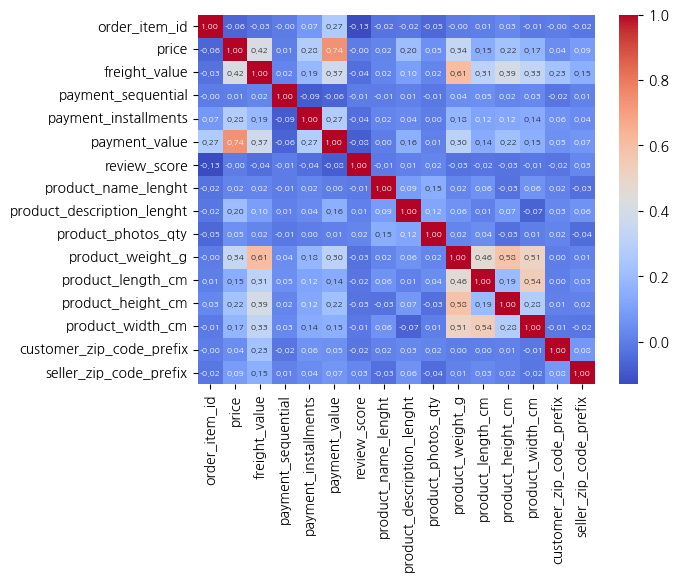

In [161]:
sns.heatmap(df_train.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"fontsize": 6})

### 상관관계 인사이트
* payment_value & price (0.74)

* payment_installments
    * price (0.28)
    * freight_value (0.19)
    * payment_value (0.27)
    * product_weight_g (0.18)
        * freight_value (0.61)
    * producut_width_cm (0.14)

# 할부 소비 패턴에 따른 판매자 전략

In [162]:
#  [소상공인/중소기업 판매자]
#         │
#         │  (상품 등록, 정보 업로드)
#         ▼
#       [Olist 플랫폼]
#         │
#         │  (카탈로그 정리, 최적화, 주문·결제·물류 처리)
#         ▼
#       [Olist Store 계정]
#         │
#         │  (공동 셀러 계정 이름으로 노출)
#         ▼
#  ┌───────────────┬───────────────┬───────────────┐
#  │ Amazon Brasil │ Mercado Livre │ Magalu/Americanas │
#  └───────────────┴───────────────┴───────────────┘
#         │
#         │  (소비자 구매)
#         ▼
#       [소비자]
#         │
#         │  (대금 결제 → Olist → 판매자 정산)
#         ▼
#  [소상공인/중소기업 판매자]


In [163]:
df_train.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state'],
      dtype='object')

In [181]:
# 1단계: 필요한 데이터셋 병합
df_analysis = pd.merge(orders, order_payments, on='order_id', how='inner')
df_analysis = pd.merge(df_analysis, order_items, on='order_id', how='inner')
df_analysis = pd.merge(df_analysis, products, on='product_id', how='inner')
df_analysis = pd.merge(df_analysis, category_name, on='product_category_name', how='inner')
df_analysis = pd.merge(df_analysis, orders, on ='order_id', how='inner')

df_analysis = df_analysis.drop_duplicates(subset=['order_id', 'product_id'])
df_analysis = df_analysis[['payment_installments', 'product_id', 'price', 'freight_value', 'payment_value', 'payment_type', 'product_category_name_english']]

df_analysis

,payment_installments,product_id,price,freight_value,payment_value,payment_type,product_category_name_english
0,1,87285b34884572647811a353c7ac498a,29.99,8.72,18.12,credit_card,housewares
3,1,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,141.46,boleto,perfumery
4,3,aa4383b373c6aca5d8797843e5594415,159.90,19.22,179.12,credit_card,auto
5,1,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20,72.20,credit_card,pet_shop
6,1,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72,28.62,credit_card,stationery
...,...,...,...,...,...,...,...
115872,3,ac35486adb7b02598c182c2ff2e05254,72.00,13.08,85.08,credit_card,health_beauty
115873,3,f1d4ce8c6dd66c47bbaa8c6781c2a923,174.90,20.10,195.00,credit_card,baby
115874,5,b80910977a37536adeddd63663f916ad,205.99,65.02,271.01,credit_card,home_appliances_2
115875,4,d1c427060a0f73f6b889a5c7c61f2ac4,179.99,40.59,441.16,credit_card,computers_accessories


In [165]:
# 2단계: 할부 개월 수에 따른 상품 분석

# 할부 개월 수에 따른 그룹 나누기
# 예시: 1-2개월 (낮은 할부), 3-6개월 (중간 할부), 7개월 이상 (높은 할부)
# 이 기준은 데이터 분포에 따라 조정 가능합니다.
bins = [0, 2, 6, 100]
labels = ['낮은 할부 (1-2개월)', '중간 할부 (3-6개월)', '높은 할부 (7개월 이상)']
df_analysis['installments_group'] = pd.cut(df_analysis['payment_installments'], bins=bins, labels=labels, right=True)

# 그룹별 분석
# 1. 그룹별 상품 종류 (가장 많이 판매된 카테고리)
print("### 1. 할부 개월 수 그룹별 가장 많이 팔린 상품 종류 (상위 5개) ###")
group_by_category = df_analysis.groupby('installments_group')['product_category_name_english'].value_counts().groupby(level=0).head(5)
print(group_by_category)
print("\n" + "-"*50 + "\n")

# 2. 그룹별 금액 (평균 가격)
print("### 2. 할부 개월 수 그룹별 평균 상품 금액 (Price) ###")
group_by_price = df_analysis.groupby('installments_group')['price'].mean().sort_values(ascending=False)
print(group_by_price)
print("\n" + "-"*50 + "\n")

# 3. 그룹별 판매량 (상품 카테고리별 판매량)
print("### 3. 할부 개월 수 그룹별 총 판매량 (상품 수) ###")
group_by_sales = df_analysis.groupby('installments_group')['product_id'].count()
print(group_by_sales)

### 1. 할부 개월 수 그룹별 가장 많이 팔린 상품 종류 (상위 5개) ###
installments_group  product_category_name_english
낮은 할부 (1-2개월)       sports_leisure                   5393
                    computers_accessories            5212
                    health_beauty                    5135
                    bed_bath_table                   4845
                    furniture_decor                  4062
중간 할부 (3-6개월)       bed_bath_table                   3438
                    health_beauty                    2691
                    watches_gifts                    1986
                    sports_leisure                   1808
                    furniture_decor                  1799
높은 할부 (7개월 이상)      bed_bath_table                   1877
                    watches_gifts                    1219
                    health_beauty                    1195
                    furniture_decor                   920
                    housewares                        771
Name: count, dtype: int64

-------

/tmp/ipython-input-1732309072.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_by_category = df_analysis.groupby('installments_group')['product_category_name_english'].value_counts().groupby(level=0).head(5)
/tmp/ipython-input-1732309072.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_by_category = df_analysis.groupby('installments_group')['product_category_name_english'].value_counts().groupby(level=0).head(5)
/tmp/ipython-input-1732309072.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to re

In [166]:
# 3단계: 고액 상품 카테고리 내 할부 개월 수별 판매율 분석

# 고액 상품 분석

# 1. 상품 카테고리별 평균 가격(price) 계산
# groupby를 사용해 product_category_name_english별로 price의 평균을 구합니다.
avg_price_by_category = df_analysis.groupby('product_category_name_english')['price'].mean()

# 2. 평균 가격을 기준으로 내림차순 정렬하여 상위 카테고리 확인
top_price_categories = avg_price_by_category.sort_values(ascending=False)

# 3. 결과 출력 (상위 20개 카테고리)
print("### 평균 가격 기준 상위 20개 상품 카테고리 ###")
print(top_price_categories.head(20))

### 평균 가격 기준 상위 20개 상품 카테고리 ###
product_category_name_english
computers                                  1141.459558
small_appliances_home_oven_and_coffee       624.285658
home_appliances_2                           483.264786
agro_industry_and_commerce                  351.167650
musical_instruments                         293.112673
small_appliances                            291.720396
construction_tools_safety                   217.560178
watches_gifts                               204.782542
furniture_bedroom                           185.867474
air_conditioning                            181.552874
cool_stuff                                  169.937600
construction_tools_construction             168.448263
office_furniture                            167.868488
kitchen_dining_laundry_garden_furniture     167.861250
fixed_telephony                             165.134194
music                                       158.798684
industry_commerce_and_business              156.240913
con

In [167]:
top_price_categories.shape

(71,)

In [168]:
top_price_categories.head(20)

,price
product_category_name_english,
computers,1141.459558
small_appliances_home_oven_and_coffee,624.285658
home_appliances_2,483.264786
agro_industry_and_commerce,351.167650
musical_instruments,293.112673
small_appliances,291.720396
construction_tools_safety,217.560178
watches_gifts,204.782542
furniture_bedroom,185.867474


In [169]:
high_value_categories = top_price_categories.head(20).index.tolist()
high_value_categories

['computers',
 'small_appliances_home_oven_and_coffee',
 'home_appliances_2',
 'agro_industry_and_commerce',
 'musical_instruments',
 'small_appliances',
 'construction_tools_safety',
 'watches_gifts',
 'furniture_bedroom',
 'air_conditioning',
 'cool_stuff',
 'construction_tools_construction',
 'office_furniture',
 'kitchen_dining_laundry_garden_furniture',
 'fixed_telephony',
 'music',
 'industry_commerce_and_business',
 'construction_tools_lights',
 'home_construction',
 'costruction_tools_tools']

In [170]:
# 3단계: 고액 상품 카테고리 내 할부 개월 수별 판매율 분석

# 1. 고액 상품 카테고리 정의 및 데이터 필터링
# 고액 상품 상위 20개
# high_value_categories = ['computers', 'small_appliances_home_oven_and_coffee', 'home_appliances_2', 'agro_industry_and_commerce', 'musical_instruments']
high_value_categories = top_price_categories.head(20).index.tolist()
df_high_value = df_analysis[df_analysis['product_category_name_english'].isin(high_value_categories)]

# 2. 고액 상품 내에서 할부 그룹별 판매량 계산
sales_by_installments = df_high_value.groupby('installments_group')['product_id'].count()
print("### 고액 상품 내 할부 개월 수 그룹별 판매량 ###")
print(sales_by_installments)
print("\n" + "-"*50 + "\n")

# 3. 고액 상품 내에서 할부 그룹별 판매율 계산
total_high_value_sales = sales_by_installments.sum()
sales_ratio_by_installments = (sales_by_installments / total_high_value_sales) * 100
print("### 고액 상품 내 할부 개월 수 그룹별 판매율(%) ###")
print(sales_ratio_by_installments.sort_values(ascending=False))

### 고액 상품 내 할부 개월 수 그룹별 판매량 ###
installments_group
낮은 할부 (1-2개월)     7907
중간 할부 (3-6개월)     4688
높은 할부 (7개월 이상)    2997
Name: product_id, dtype: int64

--------------------------------------------------

### 고액 상품 내 할부 개월 수 그룹별 판매율(%) ###
installments_group
낮은 할부 (1-2개월)     50.711904
중간 할부 (3-6개월)     30.066701
높은 할부 (7개월 이상)    19.221396
Name: product_id, dtype: float64


/tmp/ipython-input-2309302787.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_installments = df_high_value.groupby('installments_group')['product_id'].count()


In [171]:
df_high_value

,payment_installments,product_id,price,freight_value,payment_value,payment_type,product_category_name_english,installments_group
10,1,9a78fb9862b10749a117f7fc3c31f051,149.99,19.77,161.42,voucher,office_furniture,낮은 할부 (1-2개월)
19,10,638bbb2a5e4f360b71f332ddfebfd672,1299.00,77.45,1376.45,credit_card,construction_tools_construction,높은 할부 (7개월 이상)
30,1,7b717060aa783eb7f23a747a3a733dd7,109.90,15.53,125.43,boleto,cool_stuff,낮은 할부 (1-2개월)
34,8,ba74c6b75d2ad7503175809688d5a03c,178.99,13.69,192.68,credit_card,watches_gifts,높은 할부 (7개월 이상)
37,4,2d8f2be4f08788ee3bf5356af2b2ee6c,186.90,38.00,224.90,credit_card,air_conditioning,중간 할부 (3-6개월)
...,...,...,...,...,...,...,...,...
115854,4,829002c1d5f40820ebbc6ecd4bcdf3ab,150.00,23.63,173.63,credit_card,home_construction,중간 할부 (3-6개월)
115856,7,9503faef00966962beacdb4916272305,299.90,19.35,319.25,credit_card,construction_tools_construction,높은 할부 (7개월 이상)
115859,1,0a57f7d2c983bcf8188589a5fea4a8da,96.00,8.79,104.79,credit_card,watches_gifts,낮은 할부 (1-2개월)
115864,1,3d2c44374ee42b3003a470f3e937a2ea,55.90,15.14,71.04,credit_card,musical_instruments,낮은 할부 (1-2개월)


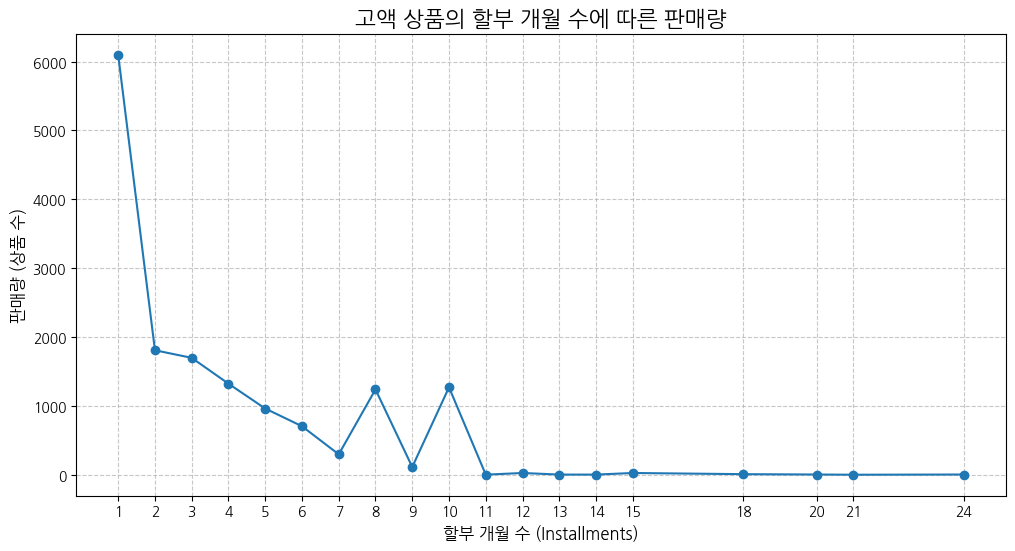

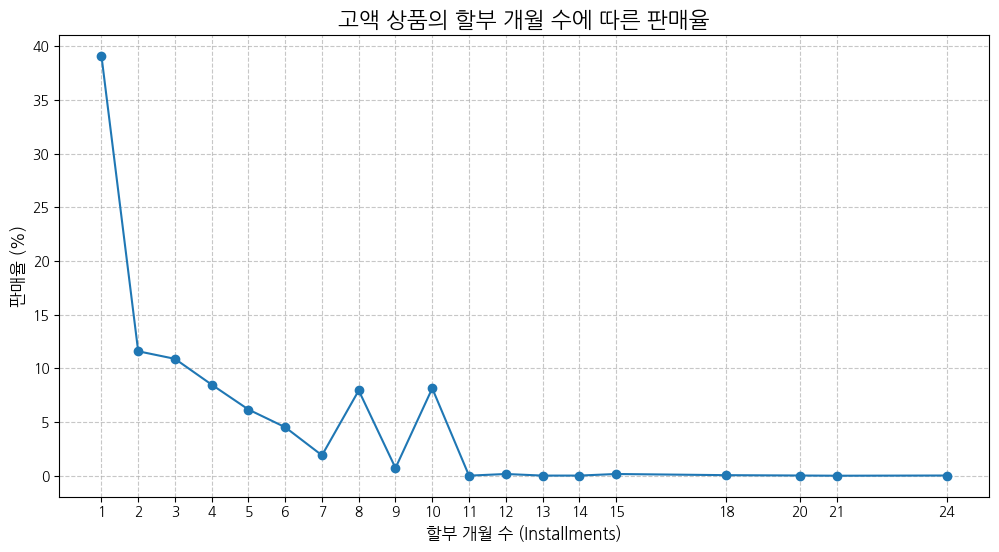

In [172]:
# 고액 상품 할부 개월수별 판매량/판매율 그래프

# 할부 개월 수별 판매량 계산
high_sales_by_installments = df_high_value.groupby('payment_installments')['product_id'].count()

# 전체 판매량 계산
high_total_sales = sales_by_installments.sum()

# --- 판매량 그래프 ---
plt.figure(figsize=(12, 6))
plt.plot(high_sales_by_installments.index, high_sales_by_installments.values, marker='o', linestyle='-')

plt.title('고액 상품의 할부 개월 수에 따른 판매량', fontsize=16)
plt.xlabel('할부 개월 수 (Installments)', fontsize=12)
plt.ylabel('판매량 (상품 수)', fontsize=12)
plt.xticks(high_sales_by_installments.index)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

# --- 판매율 그래프  ---
# 판매율(%) 계산
high_sales_percentage = (high_sales_by_installments / high_total_sales) * 100

# 라인 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(high_sales_percentage.index, high_sales_percentage.values, marker='o', linestyle='-')

# 그래프 제목과 축 레이블 설정
plt.title('고액 상품의 할부 개월 수에 따른 판매율', fontsize=16)
plt.xlabel('할부 개월 수 (Installments)', fontsize=12)
plt.ylabel('판매율 (%)', fontsize=12)
plt.xticks(high_sales_percentage.index)
plt.grid(True, linestyle='--', alpha=0.7)

# 그래프 표시
plt.show()

In [173]:
# 소액 상품과의 비교

# 1. 소액 상품 카테고리 정의 및 데이터 필터링
# 소액 상품 상위 20개
low_value_categories = top_price_categories.tail(20).index.tolist()
df_low_value = df_analysis[df_analysis['product_category_name_english'].isin(low_value_categories)]
df_low_value = df_low_value[df_low_value['payment_installments'] != 0]

# 2. 소액 상품 내에서 할부 그룹별 판매량 계산
low_sales_by_installments = df_low_value.groupby('installments_group')['product_id'].count()
print("### 소액 상품 내 할부 개월 수 그룹별 판매량 ###")
print(low_sales_by_installments)
print("\n" + "-"*50 + "\n")

# 3. 소액 상품 내에서 할부 그룹별 판매율 계산
total_low_value_sales = low_sales_by_installments.sum()
low_sales_ratio_by_installments = (low_sales_by_installments / total_low_value_sales) * 100
print("### 소액 상품 내 할부 개월 수 그룹별 판매율(%) ###")
print(low_sales_ratio_by_installments.sort_values(ascending=False))

### 소액 상품 내 할부 개월 수 그룹별 판매량 ###
installments_group
낮은 할부 (1-2개월)     8239
중간 할부 (3-6개월)     2398
높은 할부 (7개월 이상)     601
Name: product_id, dtype: int64

--------------------------------------------------

### 소액 상품 내 할부 개월 수 그룹별 판매율(%) ###
installments_group
낮은 할부 (1-2개월)     73.313757
중간 할부 (3-6개월)     21.338316
높은 할부 (7개월 이상)     5.347927
Name: product_id, dtype: float64


/tmp/ipython-input-3888908937.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  low_sales_by_installments = df_low_value.groupby('installments_group')['product_id'].count()


In [174]:
top_price_categories.tail(20).index.tolist()

['books_general_interest',
 'fashion_male_clothing',
 'books_imported',
 'fashion_underwear_beach',
 'fashion_bags_accessories',
 'arts_and_craftmanship',
 'fashion_sport',
 'books_technical',
 'fashion_childrens_clothes',
 'telephony',
 'fashio_female_clothing',
 'food',
 'christmas_supplies',
 'food_drink',
 'electronics',
 'drinks',
 'cds_dvds_musicals',
 'diapers_and_hygiene',
 'flowers',
 'home_comfort_2']

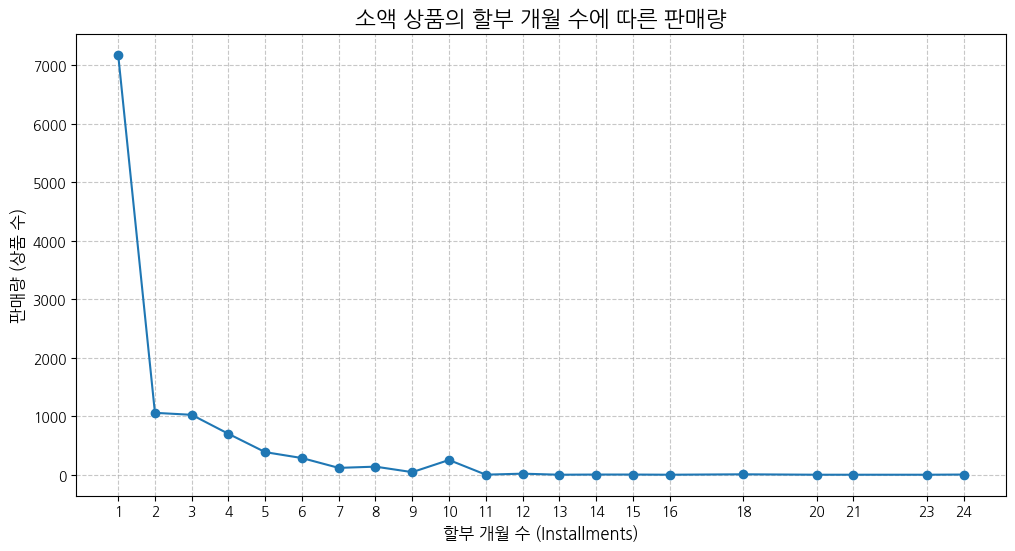

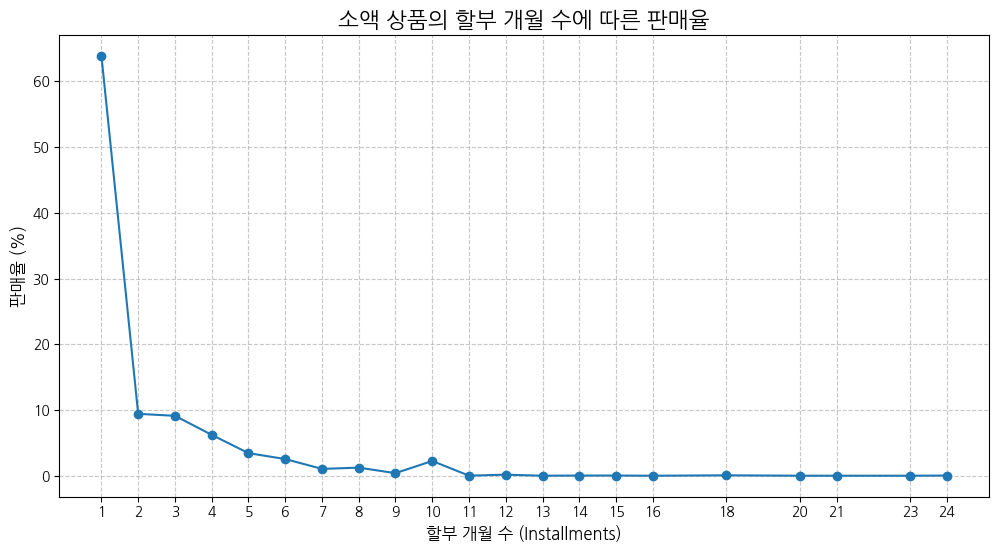

In [175]:
# 소액 상품 할부 개월수별 판매량/판매율 그래프

# 할부 개월 수별 판매량 계산
low_sales_by_installments = df_low_value.groupby('payment_installments')['product_id'].count()

# 전체 판매량 계산
low_total_sales = low_sales_by_installments.sum()

# --- 판매량 그래프 ---
plt.figure(figsize=(12, 6))
plt.plot(low_sales_by_installments.index, low_sales_by_installments.values, marker='o', linestyle='-')

plt.title('소액 상품의 할부 개월 수에 따른 판매량', fontsize=16)
plt.xlabel('할부 개월 수 (Installments)', fontsize=12)
plt.ylabel('판매량 (상품 수)', fontsize=12)
plt.xticks(low_sales_by_installments.index)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

# --- 판매율 그래프  ---
# 판매율(%) 계산
low_sales_percentage = (low_sales_by_installments / low_total_sales) * 100

# 라인 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(low_sales_percentage.index, low_sales_percentage.values, marker='o', linestyle='-')

# 그래프 제목과 축 레이블 설정
plt.title('소액 상품의 할부 개월 수에 따른 판매율', fontsize=16)
plt.xlabel('할부 개월 수 (Installments)', fontsize=12)
plt.ylabel('판매율 (%)', fontsize=12)
plt.xticks(low_sales_percentage.index)
plt.grid(True, linestyle='--', alpha=0.7)

# 그래프 표시
plt.show()

### 월별 부담액이 낮은 상품 분석

In [216]:
# 데이터셋 재생성

df_analysis_1 = pd.merge(orders, order_payments, on='order_id', how='inner')
df_analysis_1 = pd.merge(df_analysis_1, order_items, on='order_id', how='inner')
df_analysis_1 = pd.merge(df_analysis_1, products, on = 'product_id', how='inner')
df_analysis_1 = pd.merge(df_analysis_1, category_name, on='product_category_name', how='inner')

df_analysis_1

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,...,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,...,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,...,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,boleto,...,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,perfumery
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,credit_card,...,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115873,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1,credit_card,...,20.10,bebes,52.0,828.0,4.0,4950.0,40.0,10.0,40.0,baby
115874,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1,credit_card,...,65.02,eletrodomesticos_2,51.0,500.0,2.0,13300.0,32.0,90.0,22.0,home_appliances_2
115875,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1,credit_card,...,40.59,informatica_acessorios,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0,computers_accessories
115876,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1,credit_card,...,40.59,informatica_acessorios,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0,computers_accessories


In [217]:
df_analysis_1.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english'],
      dtype='object')

In [218]:
# 2. 월별 부담액(monthly_payment_amount) 계산
# payment_installments가 0인 경우를 대비하여 1로 설정 (실제 데이터에 0은 거의 없음)
df_analysis_1['monthly_payment_amount'] = df_analysis_1['payment_value'] / df_analysis_1['payment_installments'].replace(0, 1)

# 3. 분석에 필요한 컬럼만 선택하고, 중복 제거
# df_analysis_1 = df_analysis_1[['monthly_payment_amount', 'product_id', 'product_category_name_english']]
# df_analysis_1.drop_duplicates(subset=['order_id', 'product_id'], inplace=True)

In [220]:
df_analysis_1 = df_analysis_1[['monthly_payment_amount', 'product_id', 'product_category_name_english']]
# df_analysis_1.drop_duplicates(subset=['order_id', 'product_id'], inplace=True)

In [221]:
df_analysis_1

,monthly_payment_amount,product_id,product_category_name_english
0,18.120000,87285b34884572647811a353c7ac498a,housewares
1,2.000000,87285b34884572647811a353c7ac498a,housewares
2,18.590000,87285b34884572647811a353c7ac498a,housewares
3,141.460000,595fac2a385ac33a80bd5114aec74eb8,perfumery
4,59.706667,aa4383b373c6aca5d8797843e5594415,auto
...,...,...,...
115873,65.000000,f1d4ce8c6dd66c47bbaa8c6781c2a923,baby
115874,54.202000,b80910977a37536adeddd63663f916ad,home_appliances_2
115875,110.290000,d1c427060a0f73f6b889a5c7c61f2ac4,computers_accessories
115876,110.290000,d1c427060a0f73f6b889a5c7c61f2ac4,computers_accessories


In [222]:
# 1. 월별 부담액을 5개 구간(Quintiles)으로 나누기
# pd.qcut을 사용하면 각 구간에 데이터가 균등하게 분포됩니다.
# q=5는 5분위수를 의미하며, 5개의 구간으로 나눕니다.
df_analysis_1['monthly_payment_group'] = pd.qcut(
    df_analysis_1['monthly_payment_amount'],
    q=5,
    labels=['하위 20%', '20~40%', '40~60%', '60~80%', '상위 20%'],
    duplicates='drop'
)

# 2. 월별 부담액 그룹별 판매량(상품 수) 계산
print("### 월별 부담액 그룹별 판매량 ###")
sales_by_group = df_analysis_1.groupby('monthly_payment_group')['product_id'].count()
print(sales_by_group)
print("\n" + "="*50 + "\n")

# 3. 월별 부담액 그룹별 상위 상품 카테고리 분석
print("### 월별 부담액 그룹별 상위 5개 상품 카테고리 ###")
for group in df_analysis_1['monthly_payment_group'].cat.categories:
    print(f"\n--- {group} 그룹 ---")
    # 해당 그룹의 데이터만 필터링
    df_group = df_analysis_1[df_analysis_1['monthly_payment_group'] == group]

    # 상품 카테고리별 판매량 계산 (상위 5개)
    top_categories_in_group = df_group['product_category_name_english'].value_counts().head(5)
    print(top_categories_in_group)

### 월별 부담액 그룹별 판매량 ###
monthly_payment_group
하위 20%    23176
20~40%    23179
40~60%    23175
60~80%    23181
상위 20%    23167
Name: product_id, dtype: int64


### 월별 부담액 그룹별 상위 5개 상품 카테고리 ###

--- 하위 20% 그룹 ---
product_category_name_english
bed_bath_table     3370
health_beauty      1967
housewares         1955
furniture_decor    1918
telephony          1498
Name: count, dtype: int64

--- 20~40% 그룹 ---
product_category_name_english
bed_bath_table    2770
health_beauty     2587
housewares        1691
sports_leisure    1435
watches_gifts     1393
Name: count, dtype: int64

--- 40~60% 그룹 ---
product_category_name_english
furniture_decor          1936
bed_bath_table           1907
health_beauty            1793
sports_leisure           1611
computers_accessories    1327
Name: count, dtype: int64

--- 60~80% 그룹 ---
product_category_name_english
sports_leisure           2496
computers_accessories    2361
bed_bath_table           1982
health_beauty            1880
furniture_decor          1829


/tmp/ipython-input-266474767.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_group = df_analysis_1.groupby('monthly_payment_group')['product_id'].count()


In [224]:
# 1. 월별 부담액의 최댓값, 최솟값 확인 및 구간 경계 설정
min_val = df_analysis_1['monthly_payment_amount'].min()
max_val = df_analysis_1['monthly_payment_amount'].max()
print(f"월별 부담액 최솟값: {min_val:.2f}, 최댓값: {max_val:.2f}")

# 최솟값부터 최댓값까지 5개 구간으로 나눌 경계값 설정
# np.linspace는 균등한 간격의 값을 생성합니다.
bins = np.linspace(min_val, max_val, 5) # 5개 구간을 만들려면 6개의 경계값이 필요합니다.
labels = [f'구간 {i+1}' for i in range(5)]
print(f"설정된 구간 경계값: {bins}")

# 2. 월별 부담액을 '값' 기준으로 5개 구간으로 나누기
df_analysis_1['monthly_payment_group'] = pd.cut(
    df_analysis_1['monthly_payment_amount'],
    bins=bins,
    labels=labels,
    include_lowest=True, # 최솟값 포함
)

# 3. 월별 부담액 그룹별 판매량 및 상위 카테고리 분석
print("\n### 월별 부담액 그룹별 판매량 ###")
sales_by_group = df_analysis_1.groupby('monthly_payment_group')['product_id'].count()
print(sales_by_group)
print("\n" + "="*50 + "\n")

print("### 월별 부담액 그룹별 상위 5개 상품 카테고리 ###")
for group in df_analysis_1['monthly_payment_group'].cat.categories:
    print(f"\n--- {group} ---")
    df_group = df_analysis_1[df_analysis_1['monthly_payment_group'] == group]
    top_categories_in_group = df_group['product_category_name_english'].value_counts().head(5)
    print(top_categories_in_group)

월별 부담액 최솟값: 0.00, 최댓값: 13664.08
설정된 구간 경계값: [    0.     2732.816  5465.632  8198.448 10931.264 13664.08 ]

### 월별 부담액 그룹별 판매량 ###
monthly_payment_group
구간 1    115817
구간 2        41
구간 3        12
구간 4         0
구간 5         8
Name: product_id, dtype: int64


### 월별 부담액 그룹별 상위 5개 상품 카테고리 ###

--- 구간 1 ---
product_category_name_english
bed_bath_table           11823
health_beauty             9970
sports_leisure            8944
furniture_decor           8744
computers_accessories     8068
Name: count, dtype: int64

--- 구간 2 ---
product_category_name_english
computers_accessories     14
drinks                    10
signaling_and_security     6
watches_gifts              3
health_beauty              2
Name: count, dtype: int64

--- 구간 3 ---
product_category_name_english
agro_industry_and_commerce    6
fixed_telephony               4
computers                     1
art                           1
Name: count, dtype: int64

--- 구간 4 ---
Series([], Name: count, dtype: int64)

--- 구간 5 ---
pro

/tmp/ipython-input-1744732224.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_group = df_analysis_1.groupby('monthly_payment_group')['product_id'].count()


/tmp/ipython-input-829519510.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_group = df_analysis_1.groupby('monthly_payment_group')['product_id'].count()


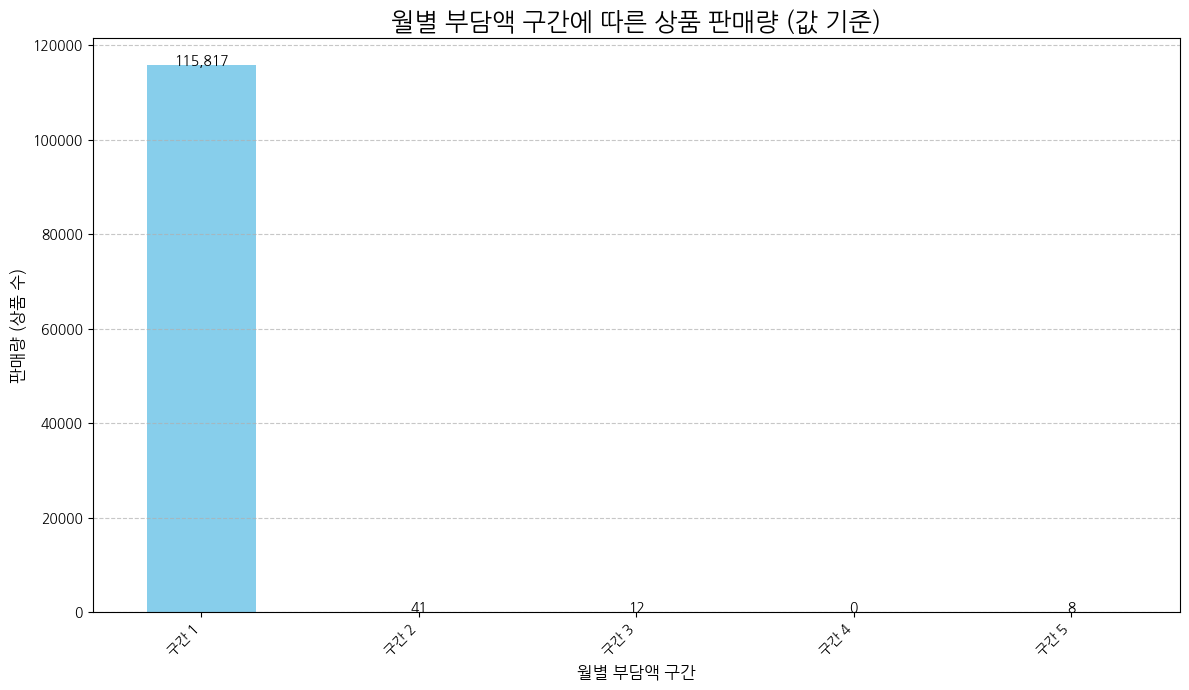

In [225]:
# 그룹별 판매량(상품 수) 계산
sales_by_group = df_analysis_1.groupby('monthly_payment_group')['product_id'].count()

# 바 차트 그리기
plt.figure(figsize=(12, 7))
sales_by_group.plot(kind='bar', color='skyblue')

# 그래프 제목과 축 레이블 설정
plt.title('월별 부담액 구간에 따른 상품 판매량 (값 기준)', fontsize=18)
plt.xlabel('월별 부담액 구간', fontsize=12)
plt.ylabel('판매량 (상품 수)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프에 각 막대의 값 표시
for index, value in enumerate(sales_by_group):
    plt.text(index, value + 100, f'{value:,}', ha='center')

plt.tight_layout()
plt.show()

/tmp/ipython-input-3234316341.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_log_group = df_analysis_1.groupby('monthly_payment_group_log')['product_id'].count()


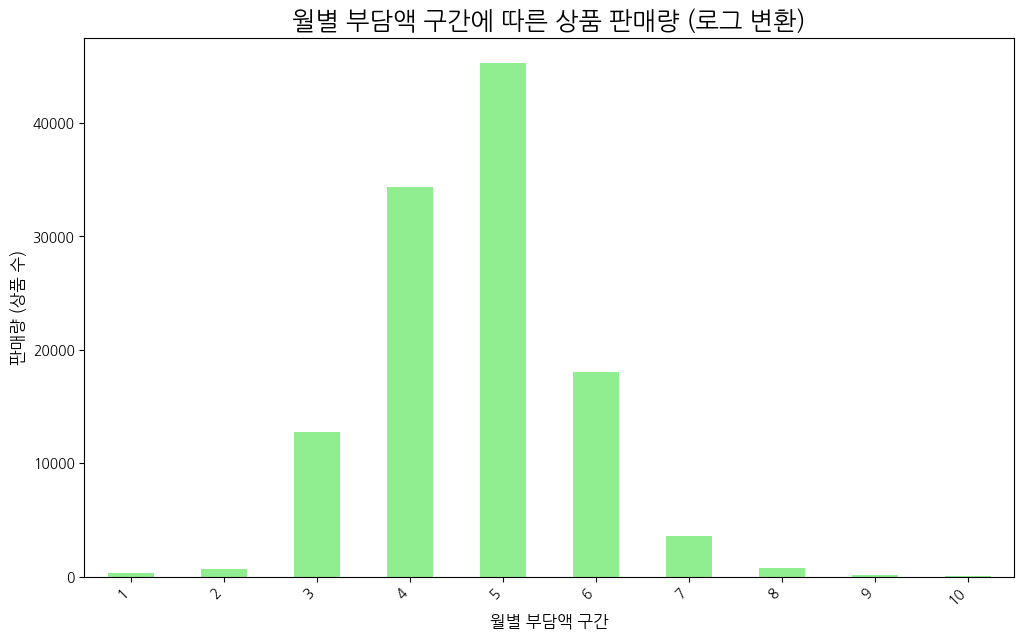

In [247]:


# 월별 부담액에 로그 변환 적용 (log1p는 log(1+x)로, 0값을 처리할 수 있습니다)
df_analysis_1['log_monthly_payment'] = np.log1p(df_analysis_1['monthly_payment_amount'])

# 로그 변환된 값을 5개 구간으로 나누기
df_analysis_1['monthly_payment_group_log'] = pd.cut(
    df_analysis_1['log_monthly_payment'],
    bins=10,
    labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
)

# 그룹별 판매량(상품 수) 계산
sales_by_log_group = df_analysis_1.groupby('monthly_payment_group_log')['product_id'].count()

# 막대 그래프 그리기 (시각화 코드는 동일)
plt.figure(figsize=(12, 7))
sales_by_log_group.plot(kind='bar', color='lightgreen')

plt.title('월별 부담액 구간에 따른 상품 판매량 (로그 변환)', fontsize=18)
plt.xlabel('월별 부담액 구간', fontsize=12)
plt.ylabel('판매량 (상품 수)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

In [228]:
# 그룹별 상위 상품 카테고리 분석
print("### 월별 부담액 로그 구간별 상위 5개 상품 카테고리 ###")
for group in df_analysis_1['monthly_payment_group_log'].cat.categories:
    print(f"\n--- {group} ---")
    df_group = df_analysis_1[df_analysis_1['monthly_payment_group_log'] == group]
    top_categories_in_group = df_group['product_category_name_english'].value_counts().head(5)
    print(top_categories_in_group)

### 월별 부담액 로그 구간별 상위 5개 상품 카테고리 ###

--- 로그 구간 1 ---
product_category_name_english
bed_bath_table           170
housewares                91
furniture_decor           72
sports_leisure            58
computers_accessories     51
Name: count, dtype: int64

--- 로그 구간 2 ---
product_category_name_english
bed_bath_table     6113
health_beauty      4660
housewares         3661
furniture_decor    3165
sports_leisure     2877
Name: count, dtype: int64

--- 로그 구간 3 ---
product_category_name_english
sports_leisure           5767
bed_bath_table           5307
computers_accessories    5218
furniture_decor          5142
health_beauty            4929
Name: count, dtype: int64

--- 로그 구간 4 ---
product_category_name_english
computers_accessories    562
furniture_decor          360
health_beauty            333
watches_gifts            264
housewares               260
Name: count, dtype: int64

--- 로그 구간 5 ---
product_category_name_english
computers_accessories         38
fixed_telephony               17

/tmp/ipython-input-468336476.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_sales_by_group = df_analysis_1.groupby(


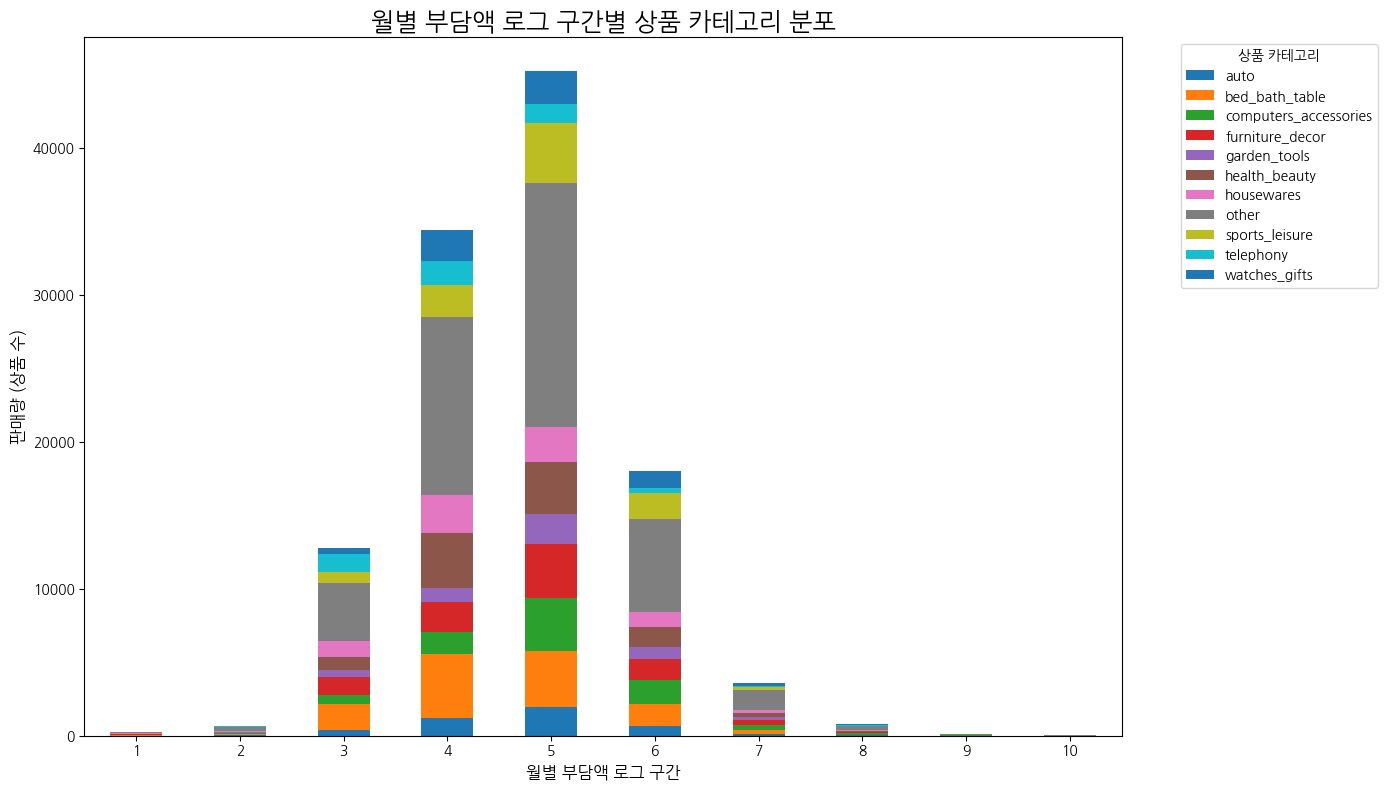

In [248]:
# 시각화를 위해 데이터 재구성
# 1. 상위 10개 카테고리만 추출, 나머지는 'other'로 통합
top_categories = df_analysis_1['product_category_name_english'].value_counts().head(10).index.tolist()
df_analysis_1['category_simplified'] = df_analysis_1['product_category_name_english'].apply(
    lambda x: x if x in top_categories else 'other'
)

# 2. 그룹 및 간소화된 카테고리별 판매량 집계
category_sales_by_group = df_analysis_1.groupby(
    ['monthly_payment_group_log', 'category_simplified']
)['product_id'].count().unstack(fill_value=0)

# Matplotlib 한글 폰트 설정
try:
    font_name = fm.FontProperties(fname='/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf').get_name()
    plt.rc('font', family=font_name)
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("나눔고딕 폰트가 설치되지 않아 기본 폰트로 출력됩니다.")

# 누적 막대 그래프 그리기
category_sales_by_group.plot(kind='bar', stacked=True, figsize=(14, 8))

# 그래프 제목과 축 레이블 설정
plt.title('월별 부담액 로그 구간별 상품 카테고리 분포', fontsize=18)
plt.xlabel('월별 부담액 로그 구간', fontsize=12)
plt.ylabel('판매량 (상품 수)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='상품 카테고리', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### 월별부담액에 따른 고객 재구매 주기

In [236]:
# 주문 + 고객 연결
orders_customers = orders.merge(customers, on="customer_id", how="left")

# customer_unique_id별 주문 횟수 집계
customer_order_counts = (
    orders_customers.groupby("customer_unique_id")["order_id"]
    .nunique()
    .reset_index(name="n_orders")
)

# 재구매 고객 판별
customer_order_counts["is_repeat_customer"] = (customer_order_counts["n_orders"] > 1).astype(int)

# 재구매 고객 수
repeat_customers = customer_order_counts["is_repeat_customer"].sum()
total_customers = customer_order_counts.shape[0]
repeat_rate = repeat_customers / total_customers

print("재구매 고객 수:", repeat_customers)
print("총 고객 수:", total_customers)
print("재구매율:", repeat_rate)

재구매 고객 수: 2997
총 고객 수: 96096
재구매율: 0.031187562437562436


In [242]:
df_analysis_2 = pd.merge(orders, order_payments, on='order_id', how='inner')
df_analysis_2 = pd.merge(df_analysis_2, order_items, on='order_id', how='inner')
df_analysis_2 = pd.merge(df_analysis_2, products, on = 'product_id', how='inner')
df_analysis_2 = pd.merge(df_analysis_2, category_name, on='product_category_name', how='inner')
df_analysis_2 = pd.merge(df_analysis_2, customers, on='customer_id', how='inner')

df_analysis_2

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,...,4.0,500.0,19.0,8.0,13.0,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,...,4.0,500.0,19.0,8.0,13.0,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,...,4.0,500.0,19.0,8.0,13.0,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,boleto,...,1.0,400.0,19.0,13.0,19.0,perfumery,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,credit_card,...,1.0,420.0,24.0,19.0,21.0,auto,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115873,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1,credit_card,...,4.0,4950.0,40.0,10.0,40.0,baby,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
115874,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1,credit_card,...,2.0,13300.0,32.0,90.0,22.0,home_appliances_2,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
115875,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1,credit_card,...,1.0,6550.0,20.0,20.0,20.0,computers_accessories,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ
115876,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1,credit_card,...,1.0,6550.0,20.0,20.0,20.0,computers_accessories,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [243]:
df_analysis_2.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state'],
      dtype='object')

/tmp/ipython-input-1910554637.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("mpa_bin")


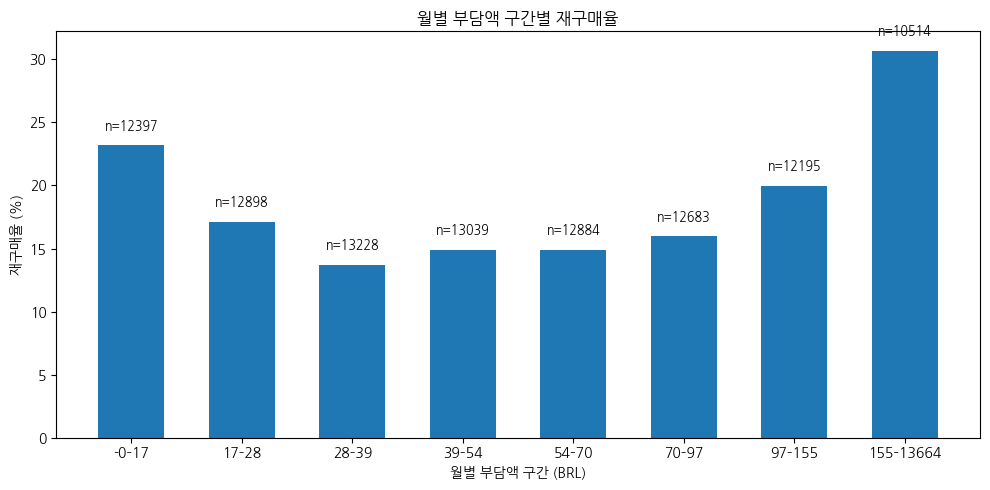

              mpa_bin  n_orders  repeat_rate    mean_mpa
0    (-0.001, 17.202]     12397     0.231826   11.755604
1    (17.202, 27.598]     12898     0.171176   22.601770
2     (27.598, 39.16]     13228     0.137076   33.241177
3      (39.16, 53.72]     13039     0.149175   46.750555
4       (53.72, 69.9]     12884     0.148772   61.177028
5       (69.9, 97.14]     12683     0.159561   82.138064
6     (97.14, 154.78]     12195     0.199945  120.945067
7  (154.78, 13664.08]     10514     0.306890  344.766672


In [244]:
df = df_analysis_2.copy()

# 방어: 분할 0 → 1로 치환
df["payment_installments"] = df["payment_installments"].fillna(1)
df.loc[df["payment_installments"] <= 0, "payment_installments"] = 1

df["monthly_payment_amount"] = df["payment_value"] / df["payment_installments"]

# ---------------------------------------------
# 1) 재구매 플래그 생성 (고객별 시계열 기준)
# ---------------------------------------------
# 타임스탬프가 문자열이면 datetime으로
if not np.issubdtype(df["order_purchase_timestamp"].dtype, np.datetime64):
    df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"], errors="coerce")

df = df.sort_values(["customer_unique_id", "order_purchase_timestamp"])
df["order_rank_by_customer"] = df.groupby("customer_unique_id")["order_purchase_timestamp"].rank(method="first")
df["is_repeat"] = (df["order_rank_by_customer"] > 1).astype(int)

# ---------------------------------------------
# 2) 월부담액 구간화 (분위수 기반)
#    - 구간 수는 bins_n으로 조절
# ---------------------------------------------
bins_n = 8  # 6~10 사이로 조절 추천
# 극단치로 인해 qcut이 실패할 수 있으니, 동일값만 많은 경우 대비 try/except
try:
    df["mpa_bin"] = pd.qcut(df["monthly_payment_amount"], q=bins_n, duplicates="drop")
except ValueError:
    # 고유값이 적으면 자동으로 구간 수 줄이기
    uniq_n = df["monthly_payment_amount"].nunique()
    df["mpa_bin"] = pd.qcut(df["monthly_payment_amount"], q=min(bins_n, max(2, uniq_n)), duplicates="drop")

# ---------------------------------------------
# 3) 구간별 재구매율 & 표본 수 집계
# ---------------------------------------------
agg = (
    df.groupby("mpa_bin")
      .agg(
          n_orders=("order_id", "nunique"),
          repeat_rate=("is_repeat", "mean"),
          mean_mpa=("monthly_payment_amount", "mean"),
      )
      .reset_index()
      .sort_values("mean_mpa")
)

# ---------------------------------------------
# 4) 시각화
#   - 막대: 재구매율(%)
#   - 막대 위에 표본 수(n) 라벨
# ---------------------------------------------
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(agg))
ax.bar(x, agg["repeat_rate"] * 100, width=0.6)

ax.set_xticks(x)
# 구간 라벨을 간단히 (하한–상한)로 표시
def bin_label(interval):
    if pd.isna(interval):
        return "NA"
    left = f"{interval.left:.0f}"
    right = f"{interval.right:.0f}"
    return f"{left}–{right}"

xticklabels = [bin_label(iv) for iv in agg["mpa_bin"]]
ax.set_xticklabels(xticklabels, rotation=0)
ax.set_ylabel("재구매율 (%)")
ax.set_xlabel("월별 부담액 구간 (BRL)")
ax.set_title("월별 부담액 구간별 재구매율")

# 막대 위에 표본 수 라벨링
for i, (rate, n) in enumerate(zip(agg["repeat_rate"], agg["n_orders"])):
    ax.text(i, rate*100 + 1, f"n={n}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# ---------------------------------------------
# 5) (선택) 결과 테이블 확인용
# ---------------------------------------------
print(agg)

/tmp/ipython-input-341159322.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("log_bin")


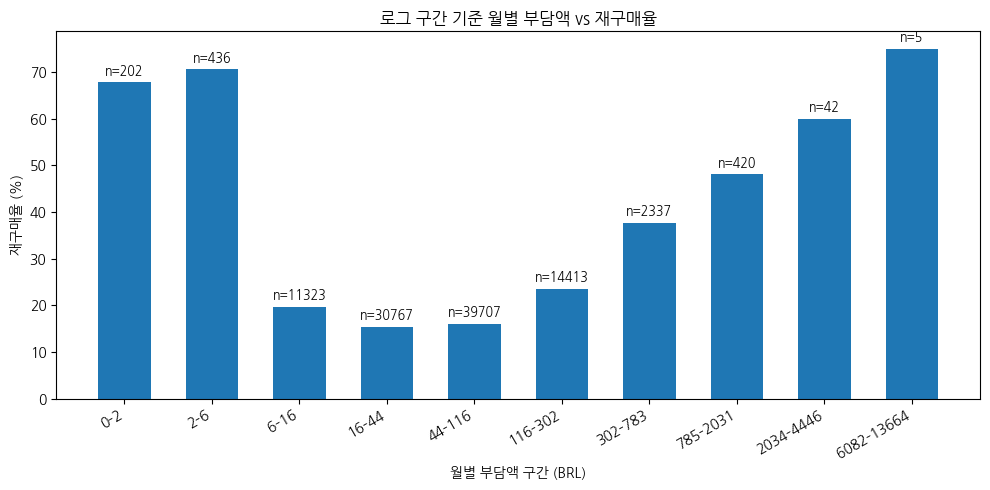

             log_bin  n_orders  repeat_rate     mean_mpa      min_mpa  \
0  (-0.00952, 0.952]       202     0.678322     0.780490     0.000000   
1     (0.952, 1.905]       436     0.705793     3.536211     1.600000   
2     (1.905, 2.857]     11323     0.197052    12.112479     5.730000   
3     (2.857, 3.809]     30767     0.154208    29.519163    16.406667   
4     (3.809, 4.761]     39707     0.160569    71.581352    44.110000   
5     (4.761, 5.714]     14413     0.235425   173.843956   115.899000   
6     (5.714, 6.666]      2337     0.377200   442.362655   302.030000   
7     (6.666, 7.618]       420     0.480670  1137.698193   785.395000   
8      (7.618, 8.57]        42     0.600000  2603.601524  2034.480000   
9      (8.57, 9.523]         5     0.750000  9427.513500  6081.540000   

    max_mpa  
0      1.58  
1      5.71  
2     16.40  
3     44.10  
4    115.89  
5    301.81  
6    783.12  
7   2031.09  
8   4445.50  
9  13664.08  


In [245]:
df = df_analysis_2.copy()

# -------------------------------
# 1) 월별 부담액 계산
# -------------------------------
df["payment_installments"] = df["payment_installments"].replace(0, 1)
df["monthly_payment_amount"] = df["payment_value"] / df["payment_installments"]

# -------------------------------
# 2) 재구매 여부 플래그
# -------------------------------
df = df.sort_values(["customer_unique_id", "order_purchase_timestamp"])
df["order_rank_by_customer"] = df.groupby("customer_unique_id")["order_purchase_timestamp"].rank(method="first")
df["is_repeat"] = (df["order_rank_by_customer"] > 1).astype(int)

# -------------------------------
# 3) 로그 변환 후 구간화
# -------------------------------
df["log_mpa"] = np.log1p(df["monthly_payment_amount"])  # log(1+x) 변환

# 로그값 구간 나누기 (예: 10개 구간)
n_bins = 10
df["log_bin"] = pd.cut(df["log_mpa"], bins=n_bins)

# -------------------------------
# 4) 구간별 집계
# -------------------------------
agg = (
    df.groupby("log_bin")
      .agg(
          n_orders=("order_id","nunique"),
          repeat_rate=("is_repeat","mean"),
          mean_mpa=("monthly_payment_amount","mean"),
          min_mpa=("monthly_payment_amount","min"),
          max_mpa=("monthly_payment_amount","max"),
      )
      .reset_index()
)

# -------------------------------
# 5) 시각화
# -------------------------------
fig, ax = plt.subplots(figsize=(10,5))

x = np.arange(len(agg))
ax.bar(x, agg["repeat_rate"]*100, width=0.6)

ax.set_xticks(x)
# 구간 라벨: 원래 금액대(min–max) 표시
xticklabels = [f"{row.min_mpa:.0f}–{row.max_mpa:.0f}" for _, row in agg.iterrows()]
ax.set_xticklabels(xticklabels, rotation=30, ha="right")

ax.set_ylabel("재구매율 (%)")
ax.set_xlabel("월별 부담액 구간 (BRL)")
ax.set_title("로그 구간 기준 월별 부담액 vs 재구매율")

# 막대 위에 표본 수 표시
for i, (rate, n) in enumerate(zip(agg["repeat_rate"], agg["n_orders"])):
    ax.text(i, rate*100+1, f"n={n}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# -------------------------------
# 6) 결과 확인
# -------------------------------
print(agg)


In [250]:
df_analysis_2.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state'],
      dtype='object')

In [253]:
# 1) 주문별 대표 카테고리(최고가 상품) 추출
items_with_price = order_items.merge(products[["product_id","product_category_name"]],
                                     on="product_id", how="left")
idx_max = items_with_price.groupby("order_id")["price"].idxmax()
items_top = items_with_price.loc[idx_max, ["order_id","product_id","price","product_category_name"]]

# 2) 번역 테이블 컬럼명 정규화 (데이터셋마다 컬럼명이 다를 수 있어 방어)
# 기대: ['product_category_name', 'product_category_name_english']
cols = [c.lower() for c in category_name.columns]
category_name.columns = cols
# 흔한 변형명 방어
if "product_category_name_english" not in category_name.columns:
    # 예: 'product_category_name_english ' 공백, 혹은 'product_category_name_translation'
    for cand in category_name.columns:
        if "english" in cand or "translation" in cand:
            category_name.rename(columns={cand: "product_category_name_english"}, inplace=True)
            break

# 3) 번역 붙이기
items_top = items_top.merge(
    category_name[["product_category_name","product_category_name_english"]],
    on="product_category_name", how="left"
)

# 4) df_analysis_1에 카테고리 붙이기
df_cat = df_analysis_2.merge(
    items_top[["order_id","product_category_name","product_category_name_english"]],
    on="order_id", how="left"
)

# 5) 혹시라도 접미사(_x/_y)가 생겼다면 정리
for cand in ["product_category_name_english_x", "product_category_name_english_y"]:
    if cand in df_cat.columns and "product_category_name_english" not in df_cat.columns:
        df_cat.rename(columns={cand: "product_category_name_english"}, inplace=True)

# 6) 최종 확인
assert "product_category_name_english" in df_cat.columns, \
    f"컬럼 없음: {df_cat.columns.tolist()}"


In [254]:
import numpy as np
# 월별 부담액 & 로그 구간
df_cat["payment_installments"] = df_cat["payment_installments"].replace(0, 1)
df_cat["monthly_payment_amount"] = df_cat["payment_value"] / df_cat["payment_installments"]
df_cat["log_mpa"] = np.log1p(df_cat["monthly_payment_amount"])
df_cat["log_bin"] = pd.cut(df_cat["log_mpa"], bins=8)

# 재구매 플래그
df_cat = df_cat.sort_values(["customer_unique_id","order_purchase_timestamp"])
df_cat["order_rank_by_customer"] = df_cat.groupby("customer_unique_id")["order_purchase_timestamp"].rank(method="first")
df_cat["is_repeat"] = (df_cat["order_rank_by_customer"] > 1).astype(int)

# (구간 × 카테고리) 집계
agg_cat = (
    df_cat.groupby(["log_bin","product_category_name_english"])
          .agg(n_orders=("order_id","nunique"),
               repeat_rate=("is_repeat","mean"),
               mean_mpa=("monthly_payment_amount","mean"))
          .reset_index()
)


/tmp/ipython-input-3327922788.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cat.groupby(["log_bin","product_category_name_english"])


/tmp/ipython-input-4207203727.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("mpa_bin")


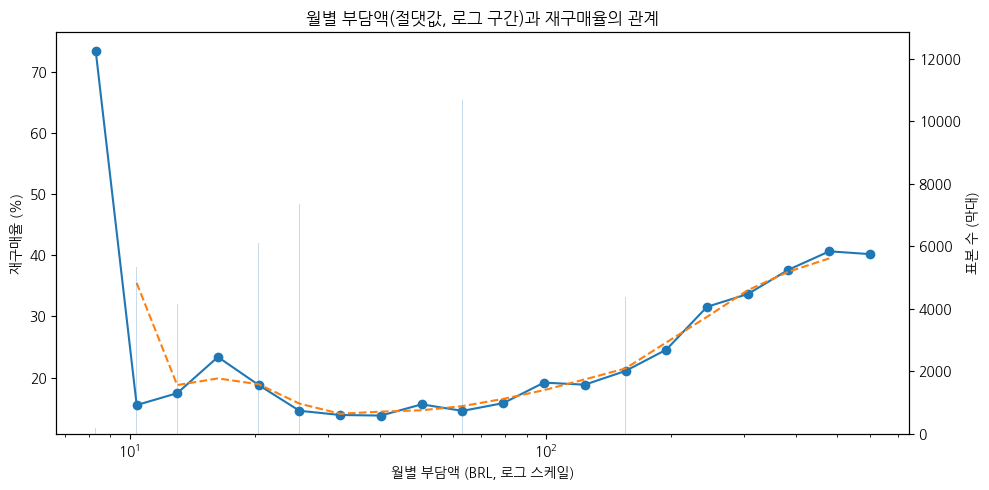

               mpa_bin  bin_center  n_orders  repeat_rate     min_mpa  \
0        [7.407, 9.28)    8.292454       198     0.734767    7.410000   
1       [9.28, 11.627)   10.403864      5334     0.154993    9.310000   
2     [11.627, 14.567)   13.014076      4151     0.174365   11.627500   
3     [14.567, 18.251)   16.305118      3177     0.233577   14.567500   
4     [18.251, 22.866)   20.431390      6100     0.187681   18.256000   
5     [22.866, 28.649)   25.594018      7340     0.145642   22.866667   
6     [28.649, 35.893)   32.067208      8421     0.138732   28.650000   
7      [35.893, 44.97)   40.172618      8415     0.137771   35.895000   
8      [44.97, 56.342)   50.334976     10700     0.156154   44.970000   
9      [56.342, 70.59)   63.062113     10687     0.145444   56.345000   
10      [70.59, 88.44)   79.012528      9194     0.158121   70.590000   
11    [88.44, 110.805)   98.993464      7365     0.191685   88.445000   
12  [110.805, 138.825)  124.034060      5802     0.

In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------
# 0) df_analysis_1 가정 컬럼:
#    order_id, customer_unique_id, order_purchase_timestamp,
#    payment_value, payment_installments
# ----------------------------------------
df = df_analysis_2.copy()

# 1) 월별 부담액 계산 (installments 0/NaN 방어)
df["payment_installments"] = df["payment_installments"].fillna(1)
df.loc[df["payment_installments"] <= 0, "payment_installments"] = 1
df["monthly_payment_amount"] = df["payment_value"] / df["payment_installments"]

# 월부담액 유효 범위(>0)만 사용
df = df[df["monthly_payment_amount"] > 0].copy()

# 2) 재구매 플래그 (고객별 시계열에서 2번째 주문부터 재구매)
if not np.issubdtype(df["order_purchase_timestamp"].dtype, np.datetime64):
    df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"], errors="coerce")

df = df.sort_values(["customer_unique_id", "order_purchase_timestamp"])
df["order_rank_by_customer"] = df.groupby("customer_unique_id")["order_purchase_timestamp"].rank(method="first")
df["is_repeat"] = (df["order_rank_by_customer"] > 1).astype(int)

# 3) 로그 구간 정의 (절댓값 기준, log-spaced bins)
#    극단치 왜곡을 줄이기 위해 1~99% 분위수 범위를 기본으로 사용
q_lo, q_hi = df["monthly_payment_amount"].quantile([0.01, 0.99])
min_val = max(1e-6, q_lo)  # 0 방지용 아주 작은 값
max_val = max(q_hi, min_val * 10)  # 상한이 하한보다 크게 보장

n_bins = 20  # 구간 개수 (상황에 맞게 12~30 사이 조절)
bin_edges = np.logspace(np.log10(min_val), np.log10(max_val), num=n_bins+1)

df["mpa_bin"] = pd.cut(df["monthly_payment_amount"], bins=bin_edges, include_lowest=True, right=False)

# 4) 구간별 평균 재구매율 및 표본 수 계산
agg = (
    df.groupby("mpa_bin")
      .agg(
          n_orders=("order_id", "nunique"),
          repeat_rate=("is_repeat", "mean"),
          min_mpa=("monthly_payment_amount", "min"),
          max_mpa=("monthly_payment_amount", "max")
      )
      .reset_index()
)

# 구간 중심값(기하평균) 계산 -> 라인 그래프 X축 좌표
# center = sqrt(min*max) (min/max가 0이 아님을 이미 보장)
agg["bin_center"] = np.sqrt(agg["min_mpa"] * agg["max_mpa"])

# 5) 소수 데이터 구간 제거 (통계적 착시 방지)
min_count = 50  # 최소 표본 수 (데이터 크기에 따라 30~200 사이 조정)
agg_f = agg[agg["n_orders"] >= min_count].sort_values("bin_center").reset_index(drop=True)

# 6) 라인 그래프 (로그 X축, 재구매율 %)
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(agg_f["bin_center"], agg_f["repeat_rate"]*100, marker="o", linewidth=1.5)

# (선택) 간단한 이동평균 스무딩(윈도=3)
if len(agg_f) >= 3:
    y = agg_f["repeat_rate"].values * 100
    y_smooth = np.convolve(y, np.ones(3)/3, mode="valid")
    x_smooth = agg_f["bin_center"].iloc[1:-1].values  # 가운데 점들에 대응
    ax.plot(x_smooth, y_smooth, linestyle="--")

ax.set_xscale("log")
ax.set_xlabel("월별 부담액 (BRL, 로그 스케일)")
ax.set_ylabel("재구매율 (%)")
ax.set_title("월별 부담액(절댓값, 로그 구간)과 재구매율의 관계")

# 보조: 구간별 표본 수를 보이기 위한 세컨더리 축(옵션)
ax2 = ax.twinx()
ax2.bar(agg_f["bin_center"], agg_f["n_orders"], width=0.07, alpha=0.25)
ax2.set_yscale("linear")
ax2.set_ylabel("표본 수 (막대)")
ax2.set_ylim(0, max(agg_f["n_orders"])*1.2)

# x축 눈금 보기 좋게 (지수 형태가 기본, 필요 시 포맷 조정 가능)
plt.tight_layout()
plt.show()

# 결과 테이블 확인
print(agg_f[["mpa_bin","bin_center","n_orders","repeat_rate","min_mpa","max_mpa"]])


In [257]:
df = df_analysis_2.copy()

# -------------------------------
# 1) 월별 부담액 계산
# -------------------------------
df["payment_installments"] = df["payment_installments"].fillna(1)
df.loc[df["payment_installments"] <= 0, "payment_installments"] = 1
df["monthly_payment_amount"] = df["payment_value"] / df["payment_installments"]

# -------------------------------
# 2) 재구매 플래그
# -------------------------------
df = df.sort_values(["customer_unique_id","order_purchase_timestamp"])
df["order_rank_by_customer"] = df.groupby("customer_unique_id")["order_purchase_timestamp"].rank(method="first")
df["is_repeat"] = (df["order_rank_by_customer"] > 1).astype(int)

# -------------------------------
# 3) 저부담 vs 고부담 그룹 나누기
# -------------------------------
threshold = 100  # BRL (상황에 따라 분위수 기반으로 조정 가능)
df_low  = df[df["monthly_payment_amount"] < threshold]
df_high = df[df["monthly_payment_amount"] >= threshold]

# -------------------------------
# 4) 재구매율 통계 검정 (proportions_ztest)
# -------------------------------
count = [df_low["is_repeat"].sum(), df_high["is_repeat"].sum()]  # 재구매한 고객 수
nobs  = [len(df_low), len(df_high)]  # 각 그룹 전체 고객 수

stat, pval = proportions_ztest(count, nobs)
print("저부담 그룹 재구매율:", count[0]/nobs[0])
print("고부담 그룹 재구매율:", count[1]/nobs[1])
print("z-statistic:", stat, "p-value:", pval)

저부담 그룹 재구매율: 0.16610465842387911
고부담 그룹 재구매율: 0.25758066256609474
z-statistic: -34.03029827707205 p-value: 7.941553769912048e-254
